In [4]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

#from IPython.display import display, Latex, clear_output

In [1]:
# WebbPSF
import webbpsf

# Interpolation and extrapolation
from scipy.interpolate import griddata, RegularGridInterpolator
from scipy.ndimage import rotate

In [2]:
# pySIAF stuff for plotting
import pysiaf
from pysiaf.siaf import Siaf
from pysiaf.siaf import plot_main_apertures

siaf = Siaf('NIRCam')
siaf.generate_toc()

In [3]:
from astropy.table import Table

In [5]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import read_filter, gen_webbpsf_siwfe, gen_psf_coeff,  field_coeff_resid, field_coeff_func
from pynrc.nrc_utils import Tel2Sci_info, NIRCam_V2V3_limits

In [6]:
# PSF setup
filter = 'F210M'
kwargs = {}
kwargs['pupil'] = None #'CIRCLYOT'

kwargs['force']     = True
kwargs['save']      = False
kwargs['save_name'] = None

bp = read_filter(filter)
channel = 'SW' if bp.avgwave() < 24000 else 'LW'
module = kwargs.get('module', 'A') # If not specified, choose 'A'
kwargs['module'] = module
# Check if coronagraphy
pupil = kwargs.get('pupil', 'CLEAR') # If not specified, choose 'A'
kwargs['pupil'] = pupil

kwargs['detector'] = None
kwargs['detector_position'] = None
kwargs['include_si_wfe'] = True

kwargs['use_legendre'] = True
fov_pix = kwargs['fov_pix'] = 33
oversample = kwargs['oversample'] = 4

kwargs['opd'] = ('OPD_RevW_ote_for_NIRCam_requirements.fits.gz', 0)
kwargs['jitter'] = 'gaussian'
kwargs['jitter_sigma'] = 0.007

In [7]:
# SI Zernike data
if (pupil is not None) and ('LYOT' in pupil):
    zfile = 'si_zernikes_coron_wfe.fits'
else:
    zfile = 'si_zernikes_isim_cv3.fits'

data_dir = webbpsf.utils.get_webbpsf_data_path() + '/'
zernike_file = data_dir + zfile
ztable_full = Table.read(zernike_file)

mod = channel + module  
ind_nrc = ['NIRCam'+mod in row['instrument'] for row in ztable_full]  
ind_nrc = np.where(ind_nrc)

v2_all = np.array(ztable_full[ind_nrc]['V2'].tolist())
v3_all = np.array(ztable_full[ind_nrc]['V3'].tolist())

In [8]:
from pynrc.nrc_utils import frebin, dist_image, hist_indices, binned_statistic
from astropy.convolution import convolve, convolve_fft, Gaussian1DKernel, Gaussian2DKernel

def do_contrast(im1, im2, header, nsig=5, supersample=True):

    data = im1 - im2

    oversamp = 1 if supersample else header['OVERSAMP']
    data_rebin = frebin(data, scale=1/oversamp)
    pixscale = oversamp*header['PIXELSCL']
    rho = dist_image(data_rebin, pixscale=pixscale)

    # Get radial profiles
    binsize = pixscale
    bins = np.arange(rho.min(), rho.max() + binsize, binsize)
    nan_mask = np.isnan(data_rebin)
    igroups, _, rr = hist_indices(rho[~nan_mask], bins, True)
    stds = binned_statistic(igroups, data_rebin[~nan_mask], func=np.std)
    stds = convolve(stds, Gaussian1DKernel(1))

    # Ignore corner regions
    arr_size = np.min(data_rebin.shape) * pixscale
    mask = rr < (arr_size/2)
    rr = rr[mask]
    stds = stds[mask]

    psf_max = frebin((im1+im2)/2, scale=1/oversamp).max()

    return rr, 5*stds/psf_max

In [9]:
# WFE Drift Values
wfe_list = [0,10]

# Do a subset, first 3 and last 3
# v2_all = np.append(v2_all[0:3], v2_all[-3:])
# v3_all = np.append(v3_all[0:3], v3_all[-3:])

v2_calc = v2_all[0:3]
v3_calc = v3_all[0:3]

apname = 'NRCA1_FULL'
ap = siaf[apname]

x1, x2, y1, y2 = np.random.randint(0,2048,size=4)
xvals, yvals = np.array([x1,x2]), np.array([y1,y2])

xvals, yvals = np.array([1000,1033]), np.array([1000,1000])
v2_calc, v3_calc = np.array(ap.sci_to_tel(xvals, yvals)) / 60

In [10]:
kwargs

{'pupil': None,
 'force': True,
 'save': False,
 'save_name': None,
 'module': 'A',
 'detector': None,
 'detector_position': None,
 'include_si_wfe': True,
 'use_legendre': True,
 'fov_pix': 33,
 'oversample': 4,
 'opd': ('OPD_RevW_ote_for_NIRCam_requirements.fits.gz', 0),
 'jitter': 'gaussian',
 'jitter_sigma': 0.007}

In [11]:
pynrc.setup_logging('WARN', verbose=False)

psf_dict = {}
for (v2, v3) in zip(v2_calc, v3_calc):
    print(v2,v3)
    d = {}
    for wfe in wfe_list:
        hdul = gen_webbpsf_siwfe(filter, (v2,v3), wfe_drift=wfe, **kwargs)
        k_wfe = 'wfe_{:.0f}nm'.format(wfe)
        d[k_wfe] = hdul

    k_si = 'V2V3_({:.2f},{:.2f})'.format(v2,v3) 
    psf_dict[k_si] = d

2.021600455850033 -8.805060841697104
NRCA1 (1000.0295816142576, 999.9751172715295) NRCA1_FULL
NRCA1 (1000.0295816142576, 999.9751172715295) NRCA1_FULL
2.004471778566748 -8.805216038200477
NRCA1 (1033.0289915291917, 999.974868689993) NRCA1_FULL
NRCA1 (1033.0289915291917, 999.974868689993) NRCA1_FULL


In [12]:
i1, i2 = (0,1) # PSF postions
j1, j2 = (0,1) # WFE drifts

keys1 = list(psf_dict.keys())
d1 = psf_dict[keys1[i1]]
d2 = psf_dict[keys1[i2]]

keys2 = list(d1.keys())
hdul1 = d1[keys2[j1]]
hdul2 = d2[keys2[j2]]

print(keys1[i1], keys2[j1])
print(keys1[i2], keys2[j2])

print(hdul1[1].data.sum(), hdul2[1].data.sum())

V2V3_(2.02,-8.81) wfe_0nm
V2V3_(2.00,-8.81) wfe_10nm
0.9094610788830289 0.9093951175167823


In [13]:
#import pynrc
#from pynrc.nrc_utils import read_filter, gen_psf_coeff, Tel2Sci_info, NIRCam_V2V3_limits, webbpsf_NIRCam_mod, field_coeff, field_model

In [14]:
pynrc.setup_logging('INFO')
nrc = pynrc.NIRCam(filter=filter, use_legendre=True, include_si_wfe=True, apname=apname, fov_pix=fov_pix, oversample=oversample)

pyNRC log messages of level INFO and above will be shown.
pyNRC log outputs will be directed to the screen.
[     pynrc:INFO] Initializing SCA 481/A1
[     pynrc:INFO] Updating PSF coeff with fov_pix=33 and oversample=4


In [15]:
nrc.wfe_drift = True
nrc.wfe_field = True

# cf_fields_grid = nrc._psf_coeff_mod['si_field'] 
# v2grid  = nrc._psf_coeff_mod['si_field_v2grid'] 
# v3grid  = nrc._psf_coeff_mod['si_field_v3grid'] 

[     pynrc:INFO] Updating PSF coeff with fov_pix=33 and oversample=4
[     pynrc:INFO] Calculating WFE Drift for fov_pix=33 and oversample=4
[     pynrc:INFO] Updating PSF coeff with fov_pix=33 and oversample=4
[     pynrc:INFO] Calculating WFE Drift for fov_pix=33 and oversample=4
[     pynrc:INFO] Calculating SI WFE Field for fov_pix=33 and oversample=4
[     pynrc:WARNING] Generating field-dependent coefficients. This may take some time...
[     pynrc:INFO] V2/V3 Coordinates and det pixel (sci) on NRCA3/NRCA3_FULL: (0.869207643, -8.776820281), (1016.14694189447, 1067.2340849714626)
[     pynrc:INFO] Generating but not saving new PSF coefficient
[     pynrc:INFO] Took 21.00 seconds to generate WebbPSF images
[     pynrc:INFO] V2/V3 Coordinates and det pixel (sci) on NRCA3/NRCA3_FULL: (0.452795003, -8.389423768), (1821.2402728416164, 1805.3712618594109)
[     pynrc:INFO] Generating but not saving new PSF coefficient
[     pynrc:INFO] Took 21.63 seconds to generate WebbPSF images
[   

In [16]:
psf1, psf1_over = nrc.gen_psf(wfe_drift=0, coord_vals=(v2_calc[0], v3_calc[0]), coord_frame='tel', return_oversample=True)
print(psf1.min(), psf1.sum())

2.021600455850033 -8.805060841697104
8.63348820715809e-07 0.9104507607733446


In [17]:
psf2, psf2_over = nrc.gen_psf(wfe_drift=10, coord_vals=(v2_calc[1], v3_calc[1]), coord_frame='tel', return_oversample=True)
print(psf2.min(), psf2.sum())

2.004471778566748 -8.805216038200477
8.121363456601233e-07 0.910382111154288


2.2993836762202294e-10 0.0005342438337815579
3.5904439447369404e-09 0.00042909006174600417
6.251575813756029e-11 0.0005288941129048489
5.88025169531649e-10 0.00041130026133915157


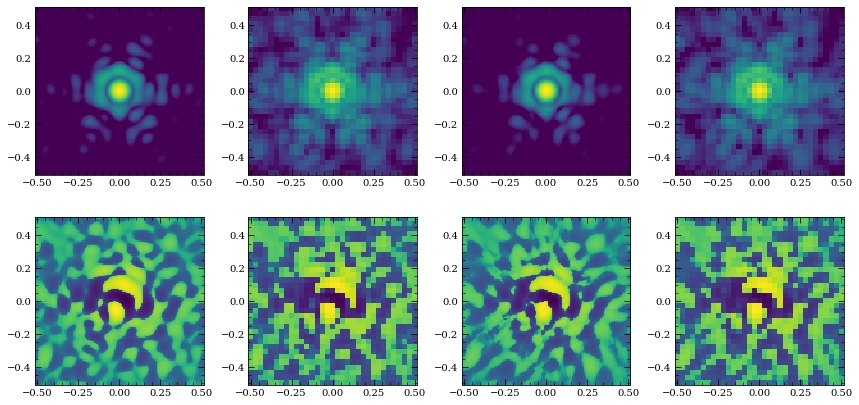

In [20]:
from matplotlib.colors import SymLogNorm, LogNorm

im1 = hdul1[0].data
im2 = hdul2[0].data
diff1 = im1 - im2

im3 = hdul1[1].data
im4 = hdul2[1].data
diff2 = im3 - im4

diff3 = psf1_over - psf2_over
diff4 = psf1 - psf2

print(np.abs(diff1).min()*16, np.abs(diff1.max())*16)
print(np.abs(diff2).min(),    np.abs(diff2.max()))
print(np.abs(diff3).min()*16, np.abs(diff3.max())*16)
print(np.abs(diff4).min(),    np.abs(diff4.max()))

sh = diff1.shape
extent = 0.5*fov_pix*np.array([-1,1,-1,1]) * nrc.pixelscale 

fig, axes = plt.subplots(2,4,figsize=(12,6))
#axes = axes.flatten()

im_list = [hdul1[0].data, hdul2[1].data, psf1_over, psf2]
for i, im in enumerate(im_list):
    ax = axes[0,i]
    ax.imshow(im, extent=extent, norm=LogNorm(vmin=1e-6))

im_list = [diff1,diff2,diff3,diff4]
for i, im in enumerate(im_list):
    ax = axes[1,i]
    ax.imshow(im, extent=extent, norm=SymLogNorm(1e-8))


    # ax.imshow(im, extent=extent, cmap='RdBu_r', norm=SymLogNorm(np.std(im)/10))

fig.tight_layout()

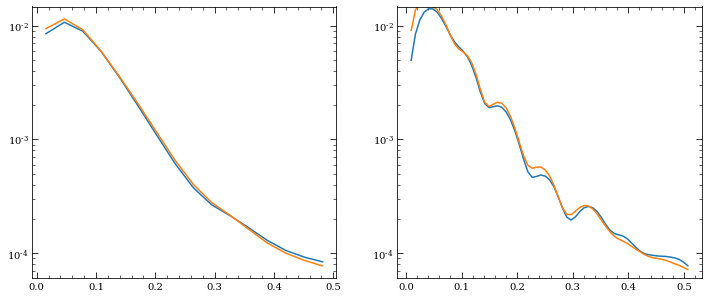

In [19]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

hdr = hdul1[1].header
rr, cont = do_contrast(hdul1[1].data, hdul2[1].data, hdr, supersample=False)
axes[0].semilogy(rr, cont)

rr, cont = do_contrast(psf1, psf2, hdr, supersample=False)
axes[0].semilogy(rr, cont)

# Oversampled PSFs

hdr = hdul1[0].header
rr, cont = do_contrast(hdul1[0].data, hdul2[0].data, hdr, supersample=True)
axes[1].semilogy(rr, cont)

rr, cont = do_contrast(psf1_over, psf2_over, hdr, supersample=True)
axes[1].semilogy(rr, cont)

for ax in axes:
    ax.set_ylim(axes[0].get_ylim())

In [194]:
coeff, head = nrc_utils.gen_psf_coeff('F444W', fov_pix=fov_pix, oversample=oversample, quick=True, save=False, force=True, 
                                      use_legendre=True, ndeg=11)

In [199]:
print(head['NPSF'], head['NDEG'])
lxmap = [head['WAVE1'], head['WAVE2']]
test = nrc_utils.jl_poly(np.array([4.4]), coeff, dim_reorder=True, use_legendre=True, lxmap=lxmap)
test[test<=0] = np.min(test[test>0])

29 11


In [200]:
print(test.min(), test.sum())

1.1149215835276275e-13 0.9802171583373691


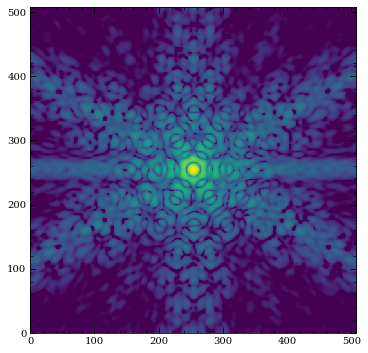

In [201]:
plt.imshow(test[:,:,0], norm=LogNorm(vmin=1e-8))

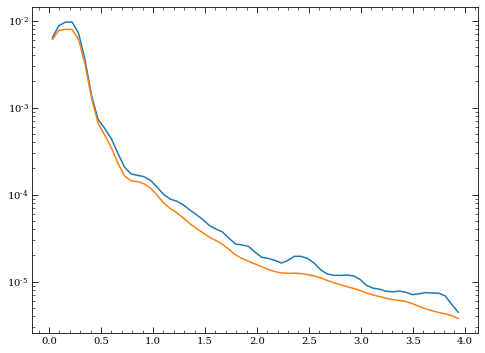

In [47]:
hdr = hdul1[0].header
rr, cont = do_contrast(hdul1[0].data, hdul2[0].data, hdr, supersample=False)
plt.semilogy(rr, cont)

rr, cont = do_contrast(psf1_over, psf2_over, hdr, supersample=False)
plt.semilogy(rr, cont)
#plt.ylim([1e-4,1e-2])

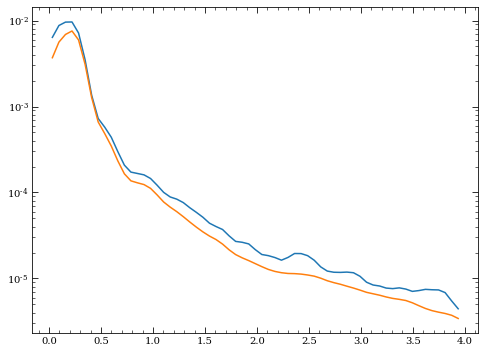

In [49]:
hdr = hdul1[0].header
rr, cont = do_contrast(hdul1[0].data, hdul2[0].data, hdr, supersample=False)
plt.semilogy(rr, cont)

rr, cont = do_contrast(psf1_over, psf2_over, hdr, supersample=False)
plt.semilogy(rr, cont)
#plt.ylim([1e-4,1e-2])

In [7]:
def gen_xygrid(module, channel, pupil=None, dstep=1./60.):

    v2_min, v2_max, v3_min, v3_max = NIRCam_V2V3_limits(module, channel, pupil=pupil)

    # Create fine mesh grid
    dstep = 1. / 60. # 1" steps
    xgrid = np.arange(v2_min, v2_max+dstep, dstep)
    ygrid = np.arange(v3_min, v3_max+dstep, dstep)
    # X, Y = np.meshgrid(xgrid,ygrid)

    return xgrid, ygrid #X, Y

def gen_zgrid(module, channel, xygrid, ztable_full, zkey='Zernike_4', **kwargs):
    """
    Cubic interpolation of irregular Zernike map 
    lookup_name can be NIRCamLWA, NIRCamLWB, NIRCamSWA, NIRCamSWB
    """
    from scipy.interpolate import griddata

    # Filter full table
    lookup_name = 'NIRCam{}{}'.format(channel, module)
    ztable = ztable_full[ztable_full['instrument'] == lookup_name]

    # V2/V3 coordinate axes
    v2 = ztable['V2']
    v3 = ztable['V3']
    # Corresponding zernike values
    zvals = ztable[zkey]    

    # Create fine mesh grid to interpolate onto
    xgrid, ygrid = gen_xygrid(module, channel, **kwargs) if xygrid is None else xygrid
    X, Y = np.meshgrid(xgrid,ygrid)

    # Cubic interpolation of all points
    zgrid = griddata((v2, v3), zvals, (X, Y), method='cubic')
    
    return zgrid

def gen_zgrid_extr(module, channel, xygrid, ztable_full, zkey='Zernike_4', 
    return_xygrid=False, **kwargs):
    """
    Create extrapolated data outside of sampled points.
    """

    xgrid, ygrid = xygrid
    
    # Gridded data from ISIM CV3 measurements
    zgrid = gen_zgrid(module, channel, ztable_full, xygrid=(xgrid, ygrid), zkey=zkey)

    # Fixed NaN's
    zgrid_fix = _fix_zgrid_NaNs(xgrid, ygrid, zgrid, rot_ang=0)
    
    return zgrid_fix


In [8]:
# SI Zernike data
data_dir = webbpsf.utils.get_webbpsf_data_path() + '/'
zernike_file = data_dir + 'si_zernikes_isim_cv3.fits'

# Read in table data
ztable_full = Table.read(zernike_file)

In [6]:
# PSF setup
filter = 'F405N'
kwargs = {}
kwargs['pupil'] = None #'CIRCLYOT'

kwargs['force']     = False
kwargs['save']      = True
kwargs['save_name'] = None

bp = read_filter(filter)
channel = 'SW' if bp.avgwave() < 24000 else 'LW'
module = kwargs.get('module', 'A') # If not specified, choose 'A'
kwargs['module'] = module
# Check if coronagraphy
pupil = kwargs.get('pupil', 'CLEAR') # If not specified, choose 'A'
kwargs['pupil'] = pupil

kwargs['detector'] = None
kwargs['detector_position'] = None
kwargs['include_si_wfe'] = True

kwargs['use_legendre'] = False
fov_pix = kwargs['fov_pix'] = 127
oversample = kwargs['oversample'] = 4

kwargs['opd'] = ('OPD_RevW_ote_for_NIRCam_requirements.fits.gz', 0)
kwargs['jitter'] = 'gaussian'
kwargs['jitter_sigma'] = 0.007

In [7]:
# SI Zernike data
if (pupil is not None) and ('LYOT' in pupil):
    zfile = 'si_zernikes_coron_wfe.fits'
else:
    zfile = 'si_zernikes_isim_cv3.fits'

data_dir = webbpsf.utils.get_webbpsf_data_path() + '/'
zernike_file = data_dir + zfile
ztable_full = Table.read(zernike_file)

mod = channel + module  
ind_nrc = ['NIRCam'+mod in row['instrument'] for row in ztable_full]  
ind_nrc = np.where(ind_nrc)

v2_all = np.array(ztable_full[ind_nrc]['V2'].tolist())
v3_all = np.array(ztable_full[ind_nrc]['V3'].tolist())

# Add detector corners
v2_min, v2_max, v3_min, v3_max = NIRCam_V2V3_limits(module, channel=channel, pupil=pupil, rederive=True, border=1)
igood = v3_all > v3_min
v2_all = np.append(v2_all[igood], [v2_min, v2_max, v2_min, v2_max])
v3_all = np.append(v3_all[igood], [v3_min, v3_min, v3_max, v3_max])


In [8]:
coeff0, cf_hdr = gen_psf_coeff(filter, **kwargs)

In [9]:
kwargs

{'pupil': None,
 'force': False,
 'save': True,
 'save_name': None,
 'module': 'A',
 'detector': None,
 'detector_position': None,
 'include_si_wfe': True,
 'use_legendre': False,
 'fov_pix': 127,
 'oversample': 4,
 'opd': ('OPD_RevW_ote_for_NIRCam_requirements.fits.gz', 0),
 'jitter': 'gaussian',
 'jitter_sigma': 0.007}

In [10]:
from pynrc.nrc_utils import field_coeff_resid
cf_fields, v2_all, v3_all = field_coeff_resid(filter, coeff0, return_raw=True, **kwargs)
#v2_corn, v3_corn = NIRCam_V2V3_limits(module, channel=channel, pupil=pupil, rederive=True, return_corners=True, border=0)

[     pynrc:WARNING] return_raw=True; Setting save=False, force=True
[     pynrc:WARNING] Generating field-dependent coefficients. This may take some time...
V2/V3 Coordinates and det pixel (sci) on NRCA5/NRCA5_FULL: (0.869207643, -8.776820281), (1561.1174212957687, 501.16111759180467)
[     pynrc:INFO] Generating but not saving new PSF coefficient
[     pynrc:INFO] Took 64.29 seconds to generate WebbPSF images
V2/V3 Coordinates and det pixel (sci) on NRCA5/NRCA5_FULL: (0.452795003, -8.389423768), (1957.8551491348626, 865.4842766560353)
[     pynrc:INFO] Generating but not saving new PSF coefficient
[     pynrc:INFO] Took 63.00 seconds to generate WebbPSF images
V2/V3 Coordinates and det pixel (sci) on NRCA5/NRCA5_FULL: (1.597543673, -9.219405725), (872.6147413098315, 83.06853207795746)
[     pynrc:INFO] Generating but not saving new PSF coefficient
[     pynrc:INFO] Took 88.02 seconds to generate WebbPSF images
V2/V3 Coordinates and det pixel (sci) on NRCA5/NRCA5_FULL: (2.403824824, -

In [9]:
pynrc.setup_logging('INFO')

pyNRC log messages of level INFO and above will be shown.
pyNRC log outputs will be directed to the screen.


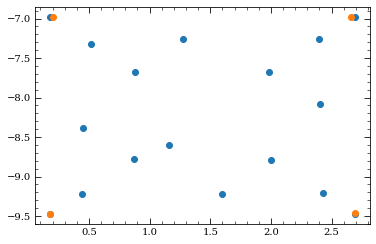

In [11]:
plt.plot(v2_all, v3_all, marker='o', ls='none')

v2_corn, v3_corn = NIRCam_V2V3_limits(module, channel=channel, pupil=pupil, rederive=True, return_corners=True, border=1)
plt.plot(v2_corn, v3_corn, marker='o', ls='none')

In [12]:
# Let's work with a single pixel and its coefficients to look at how it changes w.r.t. position
yind = xind = int(fov_pix*oversample / 2)    

# Create fine mesh grid
v2_min, v2_max = v2_all.min(), v2_all.max()
v3_min, v3_max = v3_all.min(), v3_all.max()

dstep = 1. / 60. # 1" steps
xgrid = np.arange(v2_min, v2_max+dstep, dstep)
ygrid = np.arange(v3_min, v3_max+dstep, dstep)

V2_interp, V3_interp = np.meshgrid(xgrid,ygrid)

#V2_interp = V2_interp.ravel()
#V3_interp = V3_interp.ravel()

cf_vals_one = cf_fields[:,:,0:5,0:5]
print(cf_fields.shape, cf_vals_one.shape, v2_all.shape, V2_interp.shape, cf_vals_one.shape)

(17, 11, 508, 508) (17, 11, 5, 5) (17,) (152, 152) (17, 11, 5, 5)


In [162]:
# ap = siaf['NRCA5_FULL']

# nvals = 1
# xvals = np.random.randint(0,2048,size=nvals)
# yvals = np.random.randint(0,2048,size=nvals)

# v2_new, v3_new = np.array(ap.sci_to_tel(xvals, yvals)) / 60

# isort = np.argsort(v2_new)
# v2_new = v2_new[isort]
# v3_new = v3_new[isort]

# cf_temp = cf_fields[:,0,:,:]#.reshape([17,-1,508,508])
# %time cf_grid = field_coeff_interp(v2_all, v3_all, cf_temp, v2_new, v3_new)
# print(cf_grid.shape)

CPU times: user 1.83 s, sys: 69.3 ms, total: 1.89 s
Wall time: 2.18 s
(10, 2, 508, 508)


In [36]:
cfnorm = np.abs(coeff0.reshape([11,-1]))
cfnorm = cfnorm / cfnorm.sum(axis=0)

cfstd = np.std(cfnorm, axis=1)
cfavg = np.mean(cfnorm, axis=1)

plt.semilogy(cfavg)
plt.plot(cfavg+cfstd)
plt.plot(cfavg-cfstd)

In [50]:
# Create an evenly spaced grid of V2/V3 coordinates
nv23 = 8
v2grid = np.linspace(v2_min, v2_max, num=nv23)
v3grid = np.linspace(v3_min, v3_max, num=nv23)

v2_new, v3_new = np.meshgrid(v2grid,v3grid)

sh = cf_fields.shape
cf_fields_grid = np.zeros([nv23,nv23,sh[1],sh[2],sh[3]])
# Cycle through each coefficient to interpolate onto V2/V3 grid
for i in range(sh[1]):
    print(i)
    cf_fields_grid[:,:,i,:,:] = griddata((v2_all, v3_all), cf_fields[:,i,:,:], (v2_new, v3_new), method='cubic')

0
1
2
3
4
5
6
7
8
9
10


In [55]:
print(cf_fields_grid.shape)
func = RegularGridInterpolator((v3grid, v2grid), cf_fields_grid[:,:,0,yind,xind], method='linear', bounds_error=False, fill_value=None)

pts = np.array([V3_interp, V2_interp]).transpose()
im_interp = func(pts).squeeze()

(8, 8, 11, 508, 508)


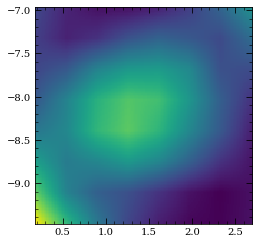

In [52]:
extent = np.array([V2_interp.min(), V2_interp.max(), V3_interp.min(), V3_interp.max()])
plt.imshow(im_interp, extent=extent)

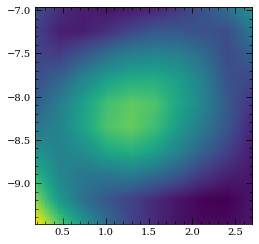

In [40]:
extent = np.array([V2_interp.min(), V2_interp.max(), V3_interp.min(), V3_interp.max()])
plt.imshow(im_interp, extent=extent)

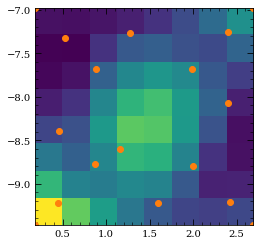

In [53]:
extent = [v2grid.min(),v2grid.max(),v3grid.min(),v3grid.max()]
plt.imshow(cf_fields_grid[:,:,0,yind,xind], extent=extent)
plt.plot(v2_all, v3_all, marker='o', ls='none', color='C1')

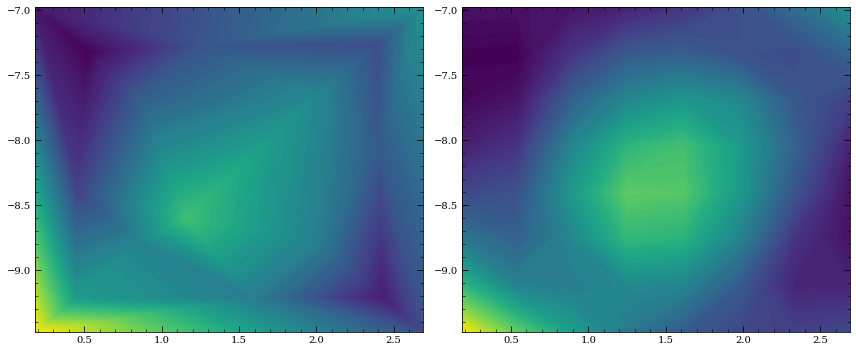

In [54]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

axes[0].tricontourf(v2_all, v3_all, cf_fields[:,0,yind,xind], levels=100)
axes[1].contourf(v2grid, v3grid, cf_fields_grid[:,:,0,yind,xind], levels=100)

fig.tight_layout()

In [31]:
%time func = RegularGridInterpolator((v3grid, v2grid), cf_fields_grid, method='linear', bounds_error=False, fill_value=None)

CPU times: user 110 µs, sys: 1e+03 ns, total: 111 µs
Wall time: 115 µs


In [165]:
pts = np.array([V3_interp, V2_interp]).transpose()
pts.shape

(132, 132, 2)

In [184]:
v2 = np.array([0.5,1,1.5])
v3 = np.array([-9, -8, -7])

pts = np.array([v2,v3]).transpose()

In [185]:
%time test = func(pts).squeeze()

CPU times: user 190 ms, sys: 37.8 ms, total: 228 ms
Wall time: 475 ms


In [187]:
test2 = coeff0 + test

In [194]:
np.size([[5,2],[4,2]])

4

In [186]:
print(pts.shape,test.shape)

(3, 2) (3, 11, 508, 508)


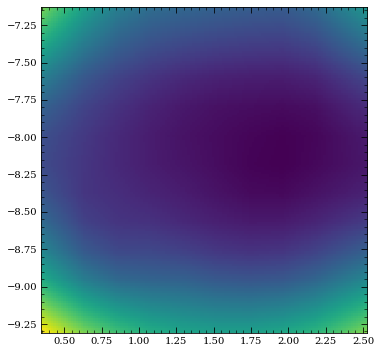

In [122]:
extent = np.array([V2_interp.min(), V2_interp.max(), V3_interp.min(), V3_interp.max()])
plt.imshow(test[:,:,0], extent=extent)

In [55]:
from scipy.interpolate import RectBivariateSpline, interp2d

In [74]:
# func = RectBivariateSpline(v3grid, v2grid, cf_grid[:,:,0,yind,xind])
func = interp2d(v2grid, v3grid, cf_grid[:,:,0,yind,xind], kind='cubic')

In [75]:
%time test = func(V2_interp[0,:].ravel(),V3_interp[:,0].ravel())

CPU times: user 1.36 ms, sys: 1.3 ms, total: 2.66 ms
Wall time: 1.99 ms


In [50]:
%time test = func(V3_interp[:,0].ravel(), V2_interp[0,:].ravel())

CPU times: user 763 µs, sys: 310 µs, total: 1.07 ms
Wall time: 851 µs


In [64]:
xt = [0,1,2];  yt = [0,3]; zt = np.array([[1,2,3], [4,5,6]])
zt.s

(2, 3)

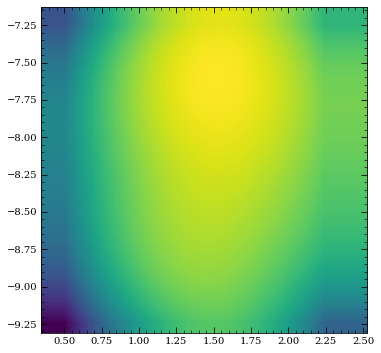

In [76]:
plt.imshow(test, extent=extent)

In [64]:
cf_temp = cf_fields.reshape([17,11,-1])
%time cf_grid = griddata((v2_all, v3_all), cf_temp, (V2_interp[0:100],V3_interp[0:100]), method='cubic')
print(cf_grid.shape)

CPU times: user 6.73 s, sys: 1.46 s, total: 8.19 s
Wall time: 8.7 s
(100, 11, 258064)


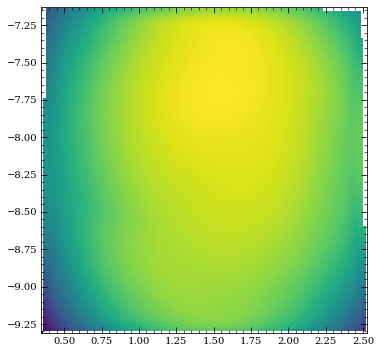

In [13]:
extent = np.array([xgrid.min(),xgrid.max(),ygrid.min(),ygrid.max()])
plt.imshow(cf_grid[:,:,0], extent=extent)

In [ ]:
# Work 

In [14]:
# least squares estimation
# X*A = Z
X = v2_all
Y = v3_all
x_fl = X.flatten().reshape([X.size, 1])
y_fl = Y.flatten().reshape([Y.size, 1])
z_ones = np.ones([X.size,1])
XX = np.hstack((x_fl**2, y_fl**2, x_fl, y_fl, z_ones))


In [15]:
Z = cf_fields.ravel()
Z = Z.reshape([X.size,-1])
#A_lsq = np.linalg.lstsq(XX,Z)[0]
q, r = np.linalg.qr(XX, 'reduced')
qTb = np.dot(q.T, Z)
A_lsq = np.linalg.lstsq(r, qTb)[0]
A_lsq = A_lsq.reshape([-1, coeff0.shape[0], coeff0.shape[1], coeff0.shape[2]])


In [110]:
print(A_lsq.shape, cf_fields.shape)

(5, 11, 508, 508) (17, 11, 508, 508)


In [16]:
from pynrc import nrc_utils
A_reshape = A_lsq[:,:,yind,xind].reshape([5,11,1,1])
test1 = field_model(V2_interp, V3_interp, A_reshape, calc_legpoly=False)

#diff1 = cf_fields - test1
#print(diff1.min(), diff1.max())

In [17]:
cf_grid2 = test1.reshape([132,132,-1])

In [27]:
ind_nan = np.isnan(cf_grid)
cf_grid[ind_nan] = cf_grid2[ind_nan]
diff = cf_grid - cf_grid2

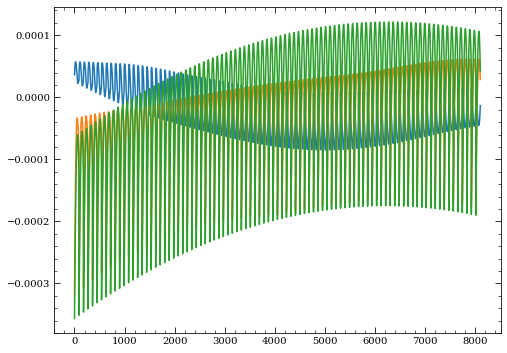

In [32]:
plt.plot(diff[10:100,10:100,0].flatten())
plt.plot(cf_grid[10:100,10:100,0].flatten())
plt.plot(cf_grid2[10:100,10:100,0].flatten())

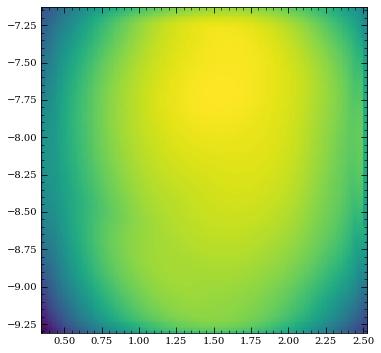

In [26]:
extent = np.array([xgrid.min(),xgrid.max(),ygrid.min(),ygrid.max()])
plt.imshow(cf_grid[:,:,0], extent=extent)

(17, 11, 508, 508)

In [89]:
test1.shape

(132, 11, 508, 508)

In [17]:
# Try Legendre polynomials
from numpy.polynomial import legendre

# Map from -1 to +1
v2_min, v2_max = v2_all.min(), v2_all.max()
v3_min, v3_max = v3_all.min(), v3_all.max()
lxmap = (v2_min, v2_max)
lymap = (v3_min, v3_max)
dx = lxmap[1] - lxmap[0]
dy = lymap[1] - lymap[0]
lx = 2 * (X - (lxmap[0] + dx/2)) / dx
ly = 2 * (Y - (lymap[0] + dy/2)) / dy

deg = 4
cxy = np.zeros((deg+1,deg+1,2*deg+1))
cxy[0,0,0] = 1
for i in np.arange(deg)+1:
    cxy[0,i,2*i] = 1
    cxy[i,0,2*i-1] = 1

XX = legendre.legval2d(lx,ly,cxy).transpose()

In [18]:
Z = cf_fields.ravel()
Z = Z.reshape([X.size,-1])
#A_lsq = np.linalg.lstsq(XX,Z)[0]
q, r = np.linalg.qr(XX, 'reduced')
qTb = np.dot(q.T, Z)
A_lsq = np.linalg.lstsq(r, qTb)[0]
A_lsq = A_lsq.reshape([-1, coeff0.shape[0], coeff0.shape[1], coeff0.shape[2]])

In [20]:
len(v2_all)

17

In [23]:
print(coeff0.shape, cf_fields.shape, Z.shape, XX.shape, A_lsq.shape)
print('ncoeff: {}, nfields: {}, nLegPoly: {}'.format(coeff0.shape[0], len(v2_all), XX.shape[1]))


(11, 132, 132) (17, 11, 132, 132) (17, 191664) (17, 9) (9, 11, 132, 132)
ncoeff: 11, nfields: 17, nLegPoly: 9


In [24]:
test2 = field_model(X, Y, A_lsq, use_legendre=True, lxmap=lxmap, lymap=lymap)

In [25]:
diff2 = cf_fields - test2
print(diff2.min(), diff2.max())

-0.0002670882468642061 0.00028112330375194985


-2.97001243366031e-05 3.0090390937306705e-05
-1.1956175914738782e-05 1.2098653809469202e-05


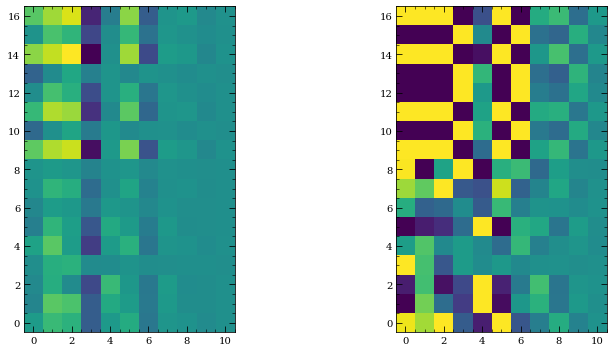

In [28]:
iy, ix = (50,60)
im1 = cf_fields[:,:,iy, ix]
im2 = cf_fields[:,:,iy, ix] - test1[:,:,iy,ix]

fig, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].imshow(im1)
axes[1].imshow(im2, vmin=-3e-6, vmax=3e-6)

print(im1.min(), im1.max())
print(im2.min(), im2.max())

fig.tight_layout()

-2.97001243366031e-05 3.0090390937306705e-05
-1.2782400719822032e-05 1.1615062928889035e-05


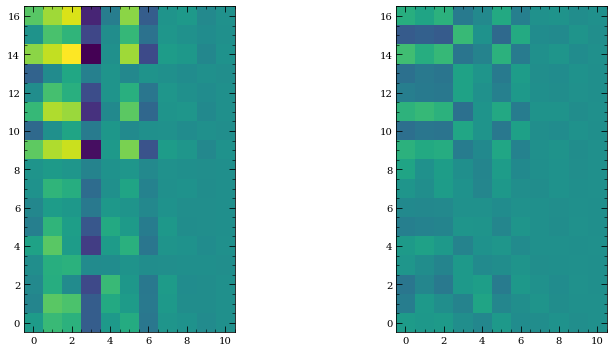

In [30]:
iy, ix = (50,60)
im1 = cf_fields[:,:,iy, ix]
im2 = cf_fields[:,:,iy, ix] - test2[:,:,iy,ix]

fig, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].imshow(im1)
axes[1].imshow(im2, vmin=-3e-5, vmax=3e-5)

print(im1.min(), im1.max())
print(im2.min(), im2.max())

fig.tight_layout()

-0.0003806573579738656 0.00031685794289667803


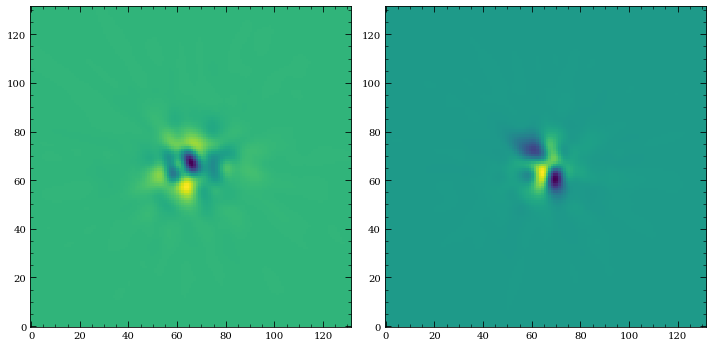

In [31]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

im1 = cf_fields[0,0,:,:]
im2 = A_lsq[-1,0,:,:] #A_lsq[10,0,:,:]
axes[0].imshow(im1)
axes[1].imshow(im2)

print(im2.min(), im2.max())

fig.tight_layout()